In [1]:
from aiida import orm, load_profile
load_profile()

from aiida_atomistic.data.structure import StructureData

import numpy as np
import matplotlib.pyplot as plt


In [2]:
from aiida_atomistic.data.structure import StructureData

# Performance test atomistic.StructureData vs orm.StructureData

- Increase linearly the number of atoms in both cases(2D plot), 
- Then see how the scaling changes if I also defined more and more related properties (2D countour plot?)

In [3]:
properties = {
    "cell":{"value":[[1,0,0],[0,1,0],[0,0,1]]},
    "positions":{"value":[[1,1,1]]},
    "symbols":{"value":["He"]},
    }

In [4]:
structure = StructureData(properties = properties)

In [5]:
structure.properties.get_stored_properties()

['pbc', 'cell', 'symbols', 'mass', 'positions']

In [6]:
legacy = orm.StructureData(cell=properties['cell']['value'])
for position,symbol in list(zip(properties['positions']['value'],properties['symbols']['value'])):
    legacy.append_atom(position=position,symbols=symbol)

## Test 1. only increasing number of atoms.

In [8]:
def generate_simple_atomistic(properties):
    return StructureData(properties = properties)

def generate_simple_orm(cell, zipped):
    legacy = orm.StructureData(cell=cell)
    for position,symbol in zipped:
        legacy.append_atom(position=position,symbols=symbol)
    
    return legacy

def timing_atomistic_and_orm(properties, factor_list=[1]):
    """
    timing function for the generation of atomistic and orm StructureData
    without considering additional properties apart cell, positions, symbols
    """
    import time
    time_list_atom = []
    time_list_orm = []
    cell = properties['cell']['value']
    initial_pos = [[1,1,1]]
    initial_symb = ['H']
    
    for factor in factor_list:
        properties['positions']['value']=initial_pos*factor
        properties['symbols']['value']=initial_symb*factor
        zipped = list(zip(properties['positions']['value'],properties['symbols']['value']))

        t_i_atom=time.time()
        atomistic = generate_simple_atomistic(properties)
        t_f_atom=time.time()
        time.sleep(0.0001)
        t_i_orm=time.time()
        legacy = generate_simple_orm(cell, zipped) 
        t_f_orm=time.time()
        time_list_atom.append(t_f_atom-t_i_atom)
        time_list_orm.append(t_f_orm-t_i_orm)
        
        properties['positions']['value']=initial_pos
        properties['symbols']['value']=initial_symb
    
    return np.array(time_list_atom),np.array(time_list_orm),np.array(factor_list)

In [9]:
properties = {
    "cell":{"value":[[1,0,0],[0,1,0],[0,0,1]]},
    "positions":{"value":[[1,1,1]]},
    "symbols":{"value":["He"]},
    }
t_atom, t_orm, factors = timing_atomistic_and_orm(properties,factor_list=list(range(500)))
#print(t_atom, t_orm, factors)

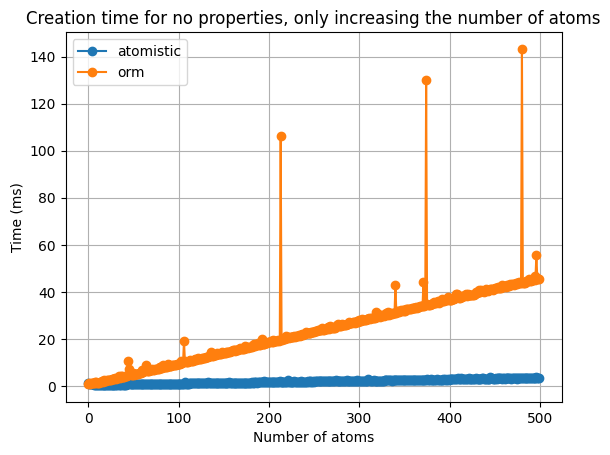

In [15]:
plt.plot(t_atom*1000, label='atomistic', marker='o')
plt.plot(t_orm*1000, label='orm', marker='o')
plt.grid()
plt.ylabel('Time (ms)')
plt.xlabel('Number of atoms')
plt.title('Creation time for no properties, only increasing the number of atoms')
plt.legend()

In [ ]:
properties

{'cell': {'value': [[1, 0, 0], [0, 1, 0], [0, 0, 1]]},
 'positions': {'value': [[1, 1, 1]]},
 'symbols': {'value': ['H']}}

## Test 2. Adding properties and increasing number of atoms.

In [20]:
def timing_atomistic_and_orm_properties(properties, factor_list=[1], props_num=2):
    """
    timing function for the generation of atomistic and orm StructureData
    considering additional properties and additional atoms.
    """
    import time
    time_list_atom = []
    time_list_orm = []
    cell = properties['cell']['value']
    initial_pos = [[1,1,1]]
    initial_symb = ['H']
    initial_charge = [1]
    initial_mass = [1]
    initial_kinds = ['H1']
    
    for factor in factor_list:
        properties['positions']['value']=initial_pos*factor
        properties['symbols']['value']=initial_symb*factor
        properties['charge']= {'value':initial_charge*factor}
        properties['mass']= {'value':initial_mass*factor}
        properties['kinds']= {'value':initial_kinds*factor}
        
        if props_num==1: 
            properties.pop('kinds')
            properties.pop('mass')
            
        elif props_num==3:
            properties.pop('kinds')
            properties.pop('charge')
        
        zipped = list(zip(properties['positions']['value'],properties['symbols']['value']))

        t_i_atom=time.time()
        atomistic = generate_simple_atomistic(properties)
        t_f_atom=time.time()
        time.sleep(0.0001)
        t_i_orm=time.time()
        legacy = generate_simple_orm(cell, zipped) 
        t_f_orm=time.time()
        time_list_atom.append(t_f_atom-t_i_atom)
        time_list_orm.append(t_f_orm-t_i_orm)
        
        properties['positions']['value']=initial_pos
        properties['symbols']['value']=initial_symb
        properties['charge']= {'value':initial_charge}
        properties['mass']= {'value':initial_mass}
        properties['kinds']= {'value':initial_kinds}
    
    return np.array(time_list_atom),np.array(time_list_orm),np.array(factor_list)

In [21]:
properties = {
    "cell":{"value":[[1,0,0],[0,1,0],[0,0,1]]},
    "positions":{"value":[[1,1,1]]},
    "symbols":{"value":["He"]},
    }
t_atom_props, t_orm_props, factors = timing_atomistic_and_orm_properties(properties,factor_list=list(range(500)))
t_atom_props_2, t_orm_props, factors = timing_atomistic_and_orm_properties(properties,factor_list=list(range(500)),props_num=1)
t_atom_props_3, t_orm_props, factors = timing_atomistic_and_orm_properties(properties,factor_list=list(range(500)),props_num=3)

#print(t_atom, t_orm, factors)

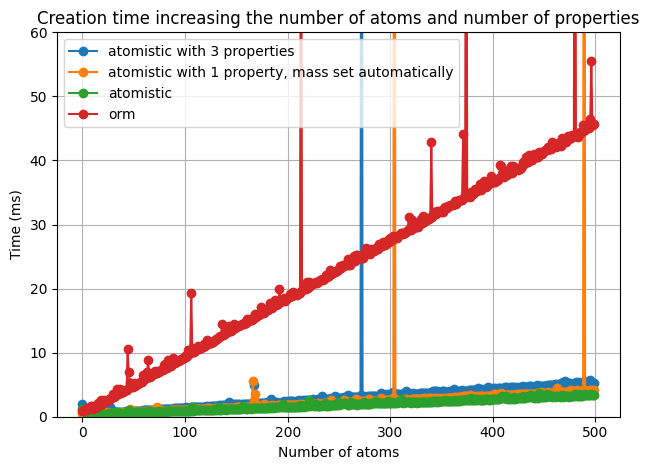

In [30]:
plt.plot(t_atom_props*1000, label='atomistic with 3 properties', marker='o')
plt.plot(t_atom_props_2*1000, label='atomistic with 1 property, mass set automatically', marker='o')
plt.plot(t_atom*1000, label='atomistic', marker='o')
plt.plot(t_orm*1000, label='orm', marker='o')
plt.ylabel('Time (ms)')
plt.xlabel('Number of atoms')
plt.title('Creation time increasing the number of atoms and number of properties')
plt.grid()
plt.ylim(0,60)
plt.legend()
plt.tight_layout()
plt.savefig('scaling.png')

The main difference is that to create the orm.StructureData we need to loop and append atoms.